In [131]:
import bdpy
import torch
import urllib
import numpy as np
import pandas as pd
import seaborn as sns
import ipywidgets as widgets  # interactive display
import matplotlib.pyplot as plt

from PIL import Image
from random import seed
from bdpy.util import get_refdata

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from xgboost import XGBClassifier

import visbrain 

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [132]:
%matplotlib inline

In [133]:
sns.set_theme(style="whitegrid")

In [173]:
regions_of_interest = {
        'CB_LHand' : 'VOX_CB_LHand = 1',
        'CB_RHand' : 'VOX_CB_RHand = 1',
        'M1_LHand' : 'VOX_M1_LHand = 1',
        'M1_RHand' : 'VOX_M1_RHand = 1',
        'SMA_LHand': 'VOX_SMA_LHand = 1',
        'SMA_RHand': 'VOX_SMA_RHand = 1',
    }

def extract_data(roi):
    data = bdpy.BData('data/S1.h5')
    
    voxel_data = data.select(regions_of_interest[roi])
    data_type = data.select('VoxelData')
    data_labels = data.select('Label')
    
    # convert labels from floats to ints
    data_labels = np.floor(data_labels).astype(int)
    
    return voxel_data, data_labels

In [174]:
def evaluate_model(model):
    # use the best hyperparams from the previous notebook
    cv_results = {}
    for roi in regions_of_interest:
        X,y = extract_data(roi)
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.33, random_state=42)
        score = cross_val_score(model, X_train, y_train.squeeze(), cv=5,scoring='accuracy')
        cv_results[roi] = score
        
    return cv_results

In [175]:
def get_result_dataframe(dictionary:dict):
    return (pd.DataFrame.from_dict(dictionary))

In [176]:
def plot_confidence_intervals(data,name):
    fig = plt.figure(figsize=(10,7))
    ax = sns.barplot(data=data, capsize=.2, ci='sd')
    ax.set_title(name)
    ax.set_ylabel('Accuracy')


In [177]:
# use the fine tuned hyperparameters
lr_model  = LogisticRegression(penalty='l2', multi_class='multinomial', random_state=42, solver='lbfgs', C=1)
svc_model = SVC(random_state=42, C=1, kernel='linear')
knn_model = KNeighborsClassifier(metric='manhattan', weights='uniform')
dt_model = DecisionTreeClassifier(random_state=42, max_depth=3, min_samples_leaf=6, min_samples_split=2)

lr_results = evaluate_model(lr_model)
svc_results = evaluate_model(svc_model)
knn_results = evaluate_model(knn_model)
dt_results = evaluate_model(dt_model)

### Looking at the individual models...

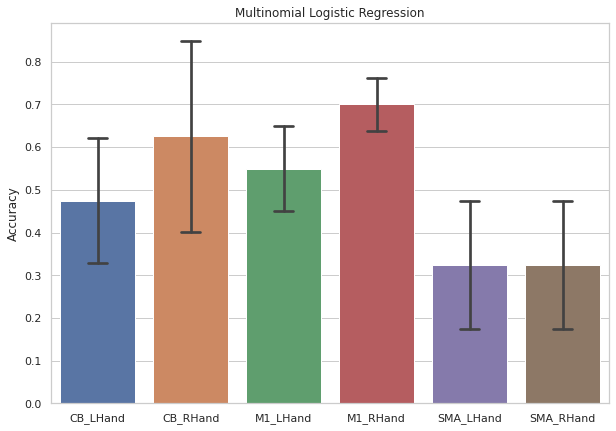

In [178]:
lr_results = get_result_dataframe(lr_results)
plot_confidence_intervals(lr_results, "Multinomial Logistic Regression")

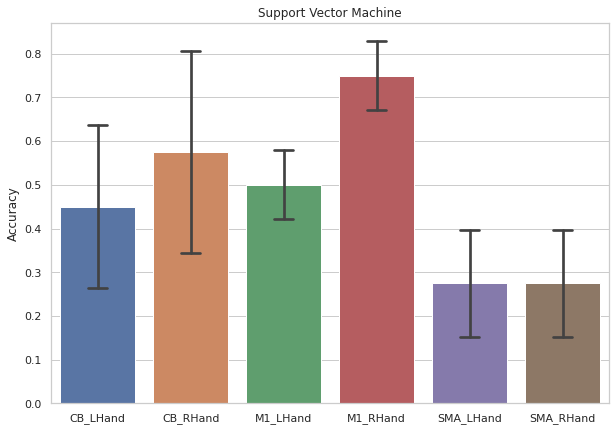

In [179]:
svc_results = get_result_dataframe(svc_results)
plot_confidence_intervals(svc_results, "Support Vector Machine")

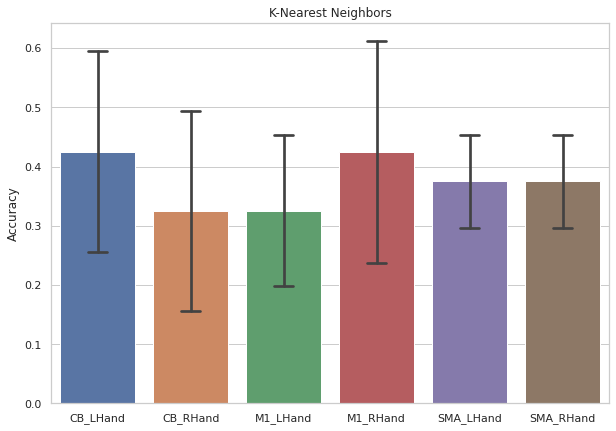

In [180]:
knn_results = get_result_dataframe(knn_results)
plot_confidence_intervals(knn_results, "K-Nearest Neighbors")

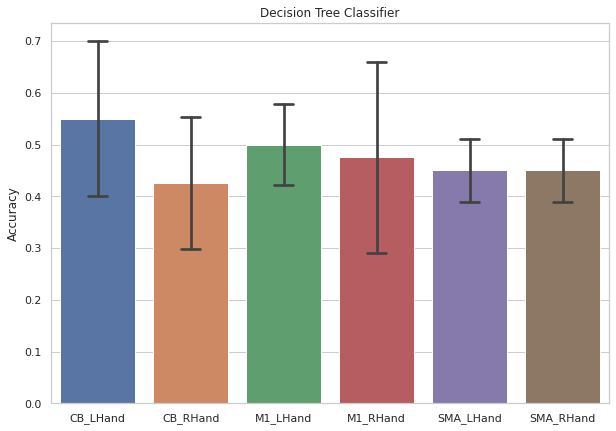

In [181]:
dt_results = get_result_dataframe(dt_results)
plot_confidence_intervals(dt_results, "Decision Tree Classifier")

### Looking at all the models side by side...

In [170]:
lr_mean_vals = lr_results.mean().to_list()
svc_mean_vals = svc_results.mean().to_list()
knn_mean_vals = knn_results.mean().to_list()
dt_mean_vals = dt_results.mean().to_list()
list_of_scores = [lr_mean_vals, svc_mean_vals, knn_mean_vals, dt_mean_vals]

In [227]:
accuracy_scores = pd.DataFrame(np.array(list_of_scores).transpose(), 
                               index=regions_of_interest, 
                               columns=['LogReg', 'SVM', 'KNN', 'DTree'])


In [228]:
accuracies

,CB_LHand,CB_RHand,M1_LHand,M1_RHand,SMA_LHand,SMA_RHand
LogReg,0.475,0.625,0.550,0.700,0.325,0.325
SVM,0.450,0.575,0.500,0.750,0.275,0.275
KNN,0.425,0.325,0.325,0.425,0.375,0.375
DTree,0.550,0.425,0.500,0.475,0.450,0.450


In [230]:
# calculate the average
cb_lhand_mean = np.mean(accuracies.CB_LHand)
cb_rhand_mean = np.mean(accuracies.CB_RHand)
m1_lhand_mean = np.mean(accuracies.M1_LHand)
m1_rhand_mean = np.mean(accuracies.M1_RHand)
sma_lhand_mean = np.mean(accuracies.SMA_LHand)
sma_rhand_mean = np.mean(accuracies.SMA_RHand)

# calculate the standard deviation
cb_lhand_std = np.std(accuracies.CB_LHand)
cb_rhand_std = np.std(accuracies.CB_RHand)
m1_lhand_std = np.std(accuracies.M1_LHand)
m1_rhand_std = np.std(accuracies.M1_RHand)
sma_lhand_std = np.std(accuracies.SMA_LHand)
sma_rhand_std = np.std(accuracies.SMA_RHand)


In [231]:
# create lists for the plot
x_pos = np.arange(len(regions_of_interest))
CTEs = [cb_lhand_mean, cb_rhand_mean, m1_lhand_mean, m1_rhand_mean, sma_lhand_mean, sma_rhand_mean]
error = [cb_lhand_std, cb_rhand_std, m1_lhand_std, m1_rhand_std, sma_lhand_std, sma_rhand_std]


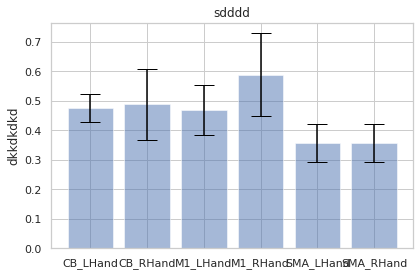

In [232]:
fig, ax = plt.subplots()
ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('dkkdkdkd')
ax.set_xticks(x_pos)
ax.set_xticklabels(regions_of_interest)
ax.set_title('sdddd')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.savefig('bar_plot_with_error_bars.png')